In [2]:
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

train = pd.read_csv('hand_gesture_data/train.csv')
test = pd.read_csv('hand_gesture_data/test.csv')
submission = pd.read_csv('hand_gesture_data/sample_submission.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 34 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         2335 non-null   int64  
 1   sensor_1   2335 non-null   float64
 2   sensor_2   2335 non-null   float64
 3   sensor_3   2335 non-null   float64
 4   sensor_4   2335 non-null   float64
 5   sensor_5   2335 non-null   float64
 6   sensor_6   2335 non-null   float64
 7   sensor_7   2335 non-null   float64
 8   sensor_8   2335 non-null   float64
 9   sensor_9   2335 non-null   float64
 10  sensor_10  2335 non-null   float64
 11  sensor_11  2335 non-null   float64
 12  sensor_12  2335 non-null   float64
 13  sensor_13  2335 non-null   float64
 14  sensor_14  2335 non-null   float64
 15  sensor_15  2335 non-null   float64
 16  sensor_16  2335 non-null   float64
 17  sensor_17  2335 non-null   float64
 18  sensor_18  2335 non-null   float64
 19  sensor_19  2335 non-null   float64
 20  sensor_2

In [4]:
train_X = train.drop(['id','target'],axis=1)
train_y = train.target

test_X = test.drop(['id'],axis=1)

print(train_X.shape, train_y.shape, test_X.shape)

(2335, 32) (2335,) (9343, 32)


In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_X, train_y, test_size = 0.2, random_state = 0)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1868, 32) (467, 32) (1868,) (467,)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [100, 120, 140],
           'max_depth' : [16, 20, 24],
           'min_samples_leaf' : [2, 4],
           'min_samples_split' : [2, 4]
            }

rf_clf = RandomForestClassifier()
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 5, n_jobs = -1)
grid_cv.fit(x_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 24, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 120}
최고 예측 정확도: 0.7639


In [7]:
rf_clf = RandomForestClassifier(n_estimators=140, 
                                max_depth=24, 
                                min_samples_leaf=2,
                                min_samples_split=4,
                                random_state=0, n_jobs = -1)
rf_clf.fit(x_train, y_train)

predict = rf_clf.predict(x_test)
print(accuracy_score(y_test,predict))

0.7558886509635975


In [8]:
pred = rf_clf.predict(test_X)

submission['target'] = pred
submission

,id,target
0,1,0
1,2,0
2,3,1
3,4,3
4,5,2
...,...,...
9338,9339,3
9339,9340,1
9340,9341,0
9341,9342,0


In [9]:
submission.to_csv('./hand_gesture_data/submit_rf_clf.csv',index=False)

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(120, input_dim=32, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

model.fit(train_X, train_y, epochs=10, batch_size=20)

print('\n Accuracy: %.4f'%(model.evaluate(train_X, train_y)[1]))

Epoch 1/10
117/117 [==============================] - 3s 4ms/step - loss: 3.0712 - accuracy: 0.3096
Epoch 2/10
117/117 [==============================] - 0s 3ms/step - loss: 1.3317 - accuracy: 0.4642
Epoch 3/10
117/117 [==============================] - 0s 4ms/step - loss: 1.0391 - accuracy: 0.5627
Epoch 4/10
117/117 [==============================] - 0s 3ms/step - loss: 0.8784 - accuracy: 0.6270
Epoch 5/10
117/117 [==============================] - 0s 4ms/step - loss: 0.7503 - accuracy: 0.6857
Epoch 6/10
117/117 [==============================] - 0s 4ms/step - loss: 0.6631 - accuracy: 0.7362
Epoch 7/10
117/117 [==============================] - 1s 4ms/step - loss: 0.5801 - accuracy: 0.7773
Epoch 8/10
117/117 [==============================] - 0s 3ms/step - loss: 0.5132 - accuracy: 0.8116
Epoch 9/10
117/117 [==============================] - 0s 4ms/step - loss: 0.4611 - accuracy: 0.8253
Epoch 10/10
73/73 [==============================] - 0s 3ms/step - loss: 0.3481 - accuracy: 0.8788



In [11]:
pred = model.predict(test_X)
predicted = pred.argmax(axis=-1)
submission['target'] = predicted
submission

,id,target
0,1,0
1,2,0
2,3,2
3,4,1
4,5,2
...,...,...
9338,9339,3
9339,9340,3
9340,9341,2
9341,9342,0


In [12]:
submission.to_csv('hand_gesture_data/submit_tf.csv',index=False)

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_X)

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

clfs = []

rf = RandomForestClassifier()
clfs.append(rf)

gbc = GradientBoostingClassifier()
clfs.append(gbc)

etc = ExtraTreesClassifier()
clfs.append(etc)

params = []

params_rf = {'n_estimators' : [100, 120, 140],
            'min_samples_split' : [2, 4, 6]}
params.append(params_rf)

params_gbc = {'learning_rate':[0.1, 0.12, 0.14, 0.16],
             'n_estimators':[100, 120, 140]}
params.append(params_gbc)

params_etc = {'n_estimators' : [100, 120, 140]}
params.append(params_etc)

In [15]:
from tqdm.auto import tqdm

def gridSearchCV(models,params):
    best_models=[]
    for i in tqdm(range(0,len(models))):
        model_grid = GridSearchCV(models[i], params[i], n_jobs = -1,verbose=1, cv=5)
        model_grid.fit(train_x,train_y)
        best_models.append(model_grid.best_estimator_)
    return best_models

best_model_list = gridSearchCV(clfs,params)

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 33%|███▎      | 1/3 [00:35<01:10, 35.25s/it]

Fitting 5 folds for each of 12 candidates, totalling 60 fits


 67%|██████▋   | 2/3 [04:34<02:35, 155.26s/it]

Fitting 5 folds for each of 3 candidates, totalling 15 fits


100%|██████████| 3/3 [04:40<00:00, 93.48s/it] 


In [16]:
best_model_list

[RandomForestClassifier(n_estimators=140),
 GradientBoostingClassifier(learning_rate=0.14, n_estimators=140),
 ExtraTreesClassifier(n_estimators=140)]

In [17]:
best_models = [
    ('rf', RandomForestClassifier(min_samples_split=6, n_estimators=120)),
    ('GBR',GradientBoostingClassifier(learning_rate=0.14, n_estimators=140)),
    ('ET', ExtraTreesClassifier(n_estimators=120))
]

from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=best_models, voting='soft')
voting_clf.fit(train_x,train_y)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(min_samples_split=6,
                                                     n_estimators=120)),
                             ('GBR',
                              GradientBoostingClassifier(learning_rate=0.14,
                                                         n_estimators=140)),
                             ('ET', ExtraTreesClassifier(n_estimators=120))],
                 voting='soft')

In [18]:
test_x = scaler.transform(test_X)
predictions = voting_clf.predict(test_x)
submission.target = predictions
submission

,id,target
0,1,0
1,2,0
2,3,1
3,4,3
4,5,2
...,...,...
9338,9339,3
9339,9340,1
9340,9341,2
9341,9342,0


In [19]:
submission.to_csv("hand_gesture_data/submit_voting_clf.csv",index = False)

In [20]:
# Basic Library
import pandas as pd
import numpy as np
import os

# Preprocessing
from sklearn.preprocessing import OneHotEncoder

# HP Tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances

# Modeling
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [21]:
train_x = train.iloc[:, 1:-1]
test_x = test.iloc[:, 1:]

train_x = np.array(train_x).reshape(-1, 8, 4, 1)
test_x = np.array(test_x).reshape(-1, 8, 4, 1)

ohe = OneHotEncoder(sparse = False)
train_y = ohe.fit_transform(train[['target']])

In [22]:
def create_model(num_layer, mid_units, num_filters):
    
    model = Sequential()
    model.add(Conv2D(filters=num_filters[0], kernel_size=(2, 2),
                 activation="elu",
                 input_shape=(8, 4, 1)))
    model.add(BatchNormalization())
    #model.add(Dropout(dropout_rate[0]))
    for i in range(1,num_layer):
        model.add(Conv2D(filters=num_filters[i], kernel_size=(2, 2), padding="same", activation="elu"))
        model.add(BatchNormalization())
        #model.add(Dropout(dropout_rate[i+1]))
            
    model.add(GlobalAveragePooling2D())
    model.add(Dense(mid_units, activation='relu'))
    #model.add(Dropout(dropout_rate[-1]))
    model.add(Dense(4, activation='softmax'))
    
    return model

In [23]:
def cnn_objective(trial: Trial) -> float:
    
    #clear_session
    keras.backend.clear_session()
    
    #number of the convolution layer
    num_layer = trial.suggest_int("num_layer", 2, 3)
    
    #number of the unit
    mid_units = int(trial.suggest_discrete_uniform("mid_units", 30, 150, 10))
    
    #number of the each convolution layer filter
    num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]

    #Dropout
    #dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    #dropout_rate = [int(trial.suggest_uniform("dropout_rate"+str(ii), 0.0, 0.5)) for ii in range(num_layer+1)]
    
        
    seed = 42
    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # Cross-validation cv=5
    es = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=0)
    cv = np.zeros((train_x.shape[0], 4))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train.target)):

        x_train, y_train = train_x[train_idx], train_y[train_idx]
        x_val, y_val = train_x[val_idx], train_y[val_idx]
        
        mc = ModelCheckpoint(f"model_{n+1}.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=0)
        
        model = create_model(num_layer, mid_units, num_filters)
        
        # Adam optimizer learning rate
        optimizer = Adam(learning_rate=trial.suggest_uniform("learning_rate", 0.0005, 0.005))
        model.compile(optimizer=optimizer,
                      loss="categorical_crossentropy",
                      metrics=["acc"])
        model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, 
                  callbacks=[es,mc], verbose=None)
        
        best = load_model(f"model_{n+1}.h5")
        
        cv[val_idx, :] = best.predict(x_val)
        
    print('multi_logloss:', log_loss(train_y, cv))
    print('accuracy_score:', accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1)))

    
    return accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1))

In [25]:
sampler = TPESampler(seed=42)
cnn_study = optuna.create_study(study_name="cnn_parameter_opt", direction="maximize", sampler=sampler)
cnn_study.optimize(cnn_objective, n_trials=20)

[I 2022-03-18 19:54:37,310] A new study created in memory with name: cnn_parameter_opt
[I 2022-03-18 19:56:42,818] Trial 0 finished with value: 0.871948608137045 and parameters: {'num_layer': 2, 'mid_units': 150.0, 'num_filter_0': 192.0, 'num_filter_1': 160.0, 'learning_rate': 0.0012020838819909643}. Best is trial 0 with value: 0.871948608137045.


multi_logloss: 0.3889943597863174
accuracy_score: 0.871948608137045


[I 2022-03-18 19:59:27,872] Trial 1 finished with value: 0.8693790149892934 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 224.0, 'num_filter_1': 160.0, 'learning_rate': 0.003686326600082205}. Best is trial 0 with value: 0.871948608137045.


multi_logloss: 0.39161130745110084
accuracy_score: 0.8693790149892934


[I 2022-03-18 20:01:38,308] Trial 2 finished with value: 0.8736616702355461 and parameters: {'num_layer': 2, 'mid_units': 150.0, 'num_filter_0': 224.0, 'num_filter_1': 64.0, 'learning_rate': 0.001318212352431953}. Best is trial 2 with value: 0.8736616702355461.


multi_logloss: 0.3877518499168593
accuracy_score: 0.8736616702355461


[I 2022-03-18 20:03:11,793] Trial 3 finished with value: 0.8753747323340471 and parameters: {'num_layer': 2, 'mid_units': 60.0, 'num_filter_0': 144.0, 'num_filter_1': 112.0, 'learning_rate': 0.0018105311308911887}. Best is trial 3 with value: 0.8753747323340471.


multi_logloss: 0.37542316992343067
accuracy_score: 0.8753747323340471


[I 2022-03-18 20:04:39,604] Trial 4 finished with value: 0.8629550321199143 and parameters: {'num_layer': 3, 'mid_units': 40.0, 'num_filter_0': 80.0, 'num_filter_1': 96.0, 'num_filter_2': 128.0, 'learning_rate': 0.004033291826268562}. Best is trial 3 with value: 0.8753747323340471.


multi_logloss: 0.4218392013493105
accuracy_score: 0.8629550321199143


[I 2022-03-18 20:05:35,816] Trial 5 finished with value: 0.8702355460385439 and parameters: {'num_layer': 2, 'mid_units': 90.0, 'num_filter_0': 160.0, 'num_filter_1': 16.0, 'learning_rate': 0.003233951833556473}. Best is trial 3 with value: 0.8753747323340471.


multi_logloss: 0.3963174740102436
accuracy_score: 0.8702355460385439


[I 2022-03-18 20:09:55,646] Trial 6 finished with value: 0.8599571734475375 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 256.0, 'num_filter_1': 256.0, 'learning_rate': 0.004137788066524076}. Best is trial 3 with value: 0.8753747323340471.


multi_logloss: 0.3920390708655281
accuracy_score: 0.8599571734475375


[I 2022-03-18 20:12:04,701] Trial 7 finished with value: 0.8805139186295503 and parameters: {'num_layer': 2, 'mid_units': 40.0, 'num_filter_0': 176.0, 'num_filter_1': 128.0, 'learning_rate': 0.0010491720568015048}. Best is trial 7 with value: 0.8805139186295503.


multi_logloss: 0.36496144237113265
accuracy_score: 0.8805139186295503


[I 2022-03-18 20:13:41,886] Trial 8 finished with value: 0.8676659528907923 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 240.0, 'num_filter_1': 80.0, 'learning_rate': 0.0034813502795929194}. Best is trial 7 with value: 0.8805139186295503.


multi_logloss: 0.3937631697509228
accuracy_score: 0.8676659528907923


[I 2022-03-18 20:14:57,046] Trial 9 finished with value: 0.8710920770877945 and parameters: {'num_layer': 2, 'mid_units': 90.0, 'num_filter_0': 144.0, 'num_filter_1': 48.0, 'learning_rate': 0.004863130824940514}. Best is trial 7 with value: 0.8805139186295503.


multi_logloss: 0.3984605448107356
accuracy_score: 0.8710920770877945


[I 2022-03-18 20:18:24,492] Trial 10 finished with value: 0.8655246252676659 and parameters: {'num_layer': 3, 'mid_units': 120.0, 'num_filter_0': 16.0, 'num_filter_1': 224.0, 'num_filter_2': 256.0, 'learning_rate': 0.00232892986962319}. Best is trial 7 with value: 0.8805139186295503.


multi_logloss: 0.43101764411720783
accuracy_score: 0.8655246252676659


[I 2022-03-18 20:20:19,100] Trial 11 finished with value: 0.867237687366167 and parameters: {'num_layer': 3, 'mid_units': 70.0, 'num_filter_0': 96.0, 'num_filter_1': 128.0, 'num_filter_2': 16.0, 'learning_rate': 0.0005620120736359543}. Best is trial 7 with value: 0.8805139186295503.


multi_logloss: 0.3848480544311974
accuracy_score: 0.867237687366167


[I 2022-03-18 20:22:00,077] Trial 12 finished with value: 0.8779443254817987 and parameters: {'num_layer': 2, 'mid_units': 60.0, 'num_filter_0': 112.0, 'num_filter_1': 128.0, 'learning_rate': 0.002073395669629205}. Best is trial 7 with value: 0.8805139186295503.


multi_logloss: 0.3671162916213578
accuracy_score: 0.8779443254817987


[I 2022-03-18 20:23:31,122] Trial 13 finished with value: 0.8676659528907923 and parameters: {'num_layer': 2, 'mid_units': 60.0, 'num_filter_0': 64.0, 'num_filter_1': 192.0, 'learning_rate': 0.002055621853617201}. Best is trial 7 with value: 0.8805139186295503.


multi_logloss: 0.3746696848035929
accuracy_score: 0.8676659528907923


[I 2022-03-18 20:26:56,307] Trial 14 finished with value: 0.8646680942184154 and parameters: {'num_layer': 3, 'mid_units': 60.0, 'num_filter_0': 176.0, 'num_filter_1': 160.0, 'num_filter_2': 256.0, 'learning_rate': 0.0027422067055176517}. Best is trial 7 with value: 0.8805139186295503.


multi_logloss: 0.4136976930008745
accuracy_score: 0.8646680942184154


[I 2022-03-18 20:28:32,030] Trial 15 finished with value: 0.8612419700214132 and parameters: {'num_layer': 2, 'mid_units': 50.0, 'num_filter_0': 112.0, 'num_filter_1': 128.0, 'learning_rate': 0.0006149727266474446}. Best is trial 7 with value: 0.8805139186295503.


multi_logloss: 0.3993599679454523
accuracy_score: 0.8612419700214132


[I 2022-03-18 20:30:00,722] Trial 16 finished with value: 0.8749464668094219 and parameters: {'num_layer': 2, 'mid_units': 80.0, 'num_filter_0': 48.0, 'num_filter_1': 192.0, 'learning_rate': 0.0014613695850601305}. Best is trial 7 with value: 0.8805139186295503.


multi_logloss: 0.37291920559811353
accuracy_score: 0.8749464668094219


[I 2022-03-18 20:31:54,333] Trial 17 finished with value: 0.8740899357601714 and parameters: {'num_layer': 3, 'mid_units': 120.0, 'num_filter_0': 112.0, 'num_filter_1': 96.0, 'num_filter_2': 32.0, 'learning_rate': 0.0028120172456638955}. Best is trial 7 with value: 0.8805139186295503.


multi_logloss: 0.4113834134835463
accuracy_score: 0.8740899357601714


[I 2022-03-18 20:33:13,038] Trial 18 finished with value: 0.8702355460385439 and parameters: {'num_layer': 2, 'mid_units': 50.0, 'num_filter_0': 192.0, 'num_filter_1': 32.0, 'learning_rate': 0.0010201558125874047}. Best is trial 7 with value: 0.8805139186295503.


multi_logloss: 0.37757282015388505
accuracy_score: 0.8702355460385439


[I 2022-03-18 20:34:35,669] Trial 19 finished with value: 0.8676659528907923 and parameters: {'num_layer': 2, 'mid_units': 100.0, 'num_filter_0': 128.0, 'num_filter_1': 192.0, 'learning_rate': 0.0018177876401443216}. Best is trial 7 with value: 0.8805139186295503.


multi_logloss: 0.3860681358007376
accuracy_score: 0.8676659528907923


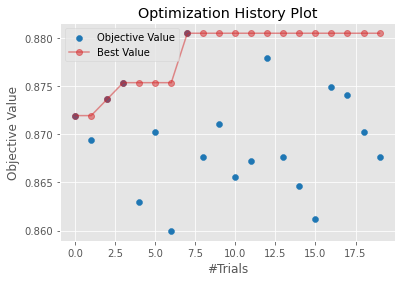

In [26]:
optuna.visualization.matplotlib.plot_optimization_history(cnn_study);

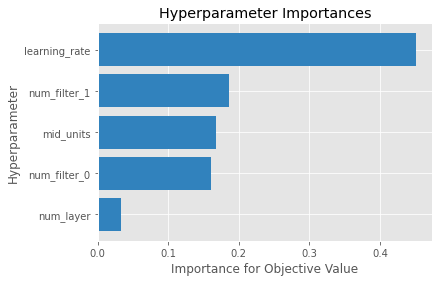

In [27]:
optuna.visualization.matplotlib.plot_param_importances(cnn_study);

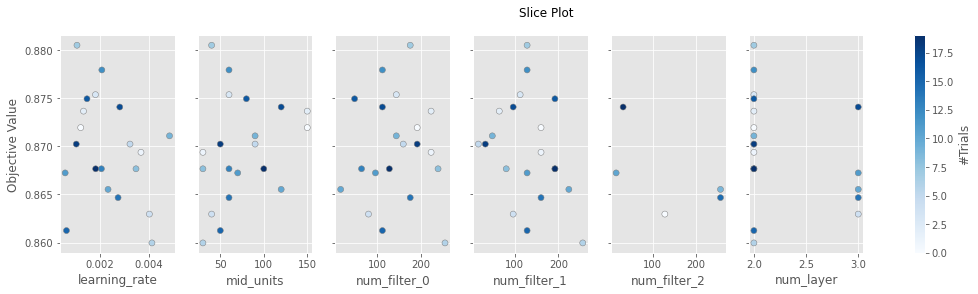

In [28]:
optuna.visualization.matplotlib.plot_slice(cnn_study);

In [29]:
cnn_acc = []
cnn_pred = np.zeros((test_x.shape[0], 4))
seed = 42
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
es = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=0)

for i, (train_idx, val_idx) in enumerate(skf.split(train_x, train.target)):
    print(f"{i+1} Fold Training.....")
    x_train, y_train = train_x[train_idx], train_y[train_idx]
    x_val, y_val = train_x[val_idx], train_y[val_idx]
    
    cnn = create_model(cnn_study.best_params['num_layer'], cnn_study.best_params['mid_units'], 
                      [cnn_study.best_params[f'num_filter_{i}'] for i in range(cnn_study.best_params['num_layer'])])
    
    # ModelCheckpoint Fold마다 갱신
    mc = ModelCheckpoint(f"model_{i+1}.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=0)
    
    # 모델 Complie
    optimizer = Adam(learning_rate=cnn_study.best_params['learning_rate'])
    cnn.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])
    cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks=[es,mc], verbose=0)
    
    # 최고 성능 기록 모델
    best = load_model(f"model_{i+1}.h5")
    
    val_pred = best.predict(x_val)
    
    val_cls = np.argmax(val_pred, axis=1)
    
    fold_cnn_acc = accuracy_score(np.argmax(y_val, axis=1), val_cls)
    cnn_acc.append(fold_cnn_acc)
    print(f"{i+1} Fold ACC of CNN = {fold_cnn_acc}\n")
    
    fold_pred = best.predict(test_x) / skf.n_splits
    cnn_pred += fold_pred

1 Fold Training.....
1 Fold ACC of CNN = 0.8565310492505354

2 Fold Training.....
2 Fold ACC of CNN = 0.9014989293361885

3 Fold Training.....
3 Fold ACC of CNN = 0.8693790149892934

4 Fold Training.....
4 Fold ACC of CNN = 0.8436830835117773

5 Fold Training.....
5 Fold ACC of CNN = 0.8843683083511777



In [30]:
np.mean(cnn_acc)

0.8710920770877945

In [31]:
submission['target'] = np.argmax(cnn_pred, axis = 1)
submission

,id,target
0,1,0
1,2,0
2,3,1
3,4,3
4,5,2
...,...,...
9338,9339,3
9339,9340,1
9340,9341,0
9341,9342,0


In [32]:
submission.to_csv('hand_gesture_data/submission_CNN.csv', index = False)